# ECG Feature Extraction using WTdelineator
This notebook integrates the Wavelet-based ECG delineator (`WTdelineator.py`) with the feature extraction pipeline.

In [1]:

import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from scipy.stats import skew, kurtosis
import WTdelineator as wav  # Import wavelet-based delineator


In [ ]:
# Load 500 Hz high-resolution ECG from PTB-XL
data_folder = "Dataset/ptbxl_data"
record_path = data_folder + "/records500/00000/00001_hr"

signal, fields = wfdb.rdsamp(record_path)
fs = 500  # update sampling frequency
lead_sig = signal[:, 1]  # use lead II

# Run delineation on raw 500 Hz signal
Pwav, QRS, Twav = wav.signalDelineation(lead_sig, fs)
P_on, P_off = Pwav[:, 0], Pwav[:, 3]
Q_on, S_off = QRS[:, 0], QRS[:, 4]
R_pk = QRS[:, 2]
T_on, T_off = Twav[:, 0], Twav[:, 3]


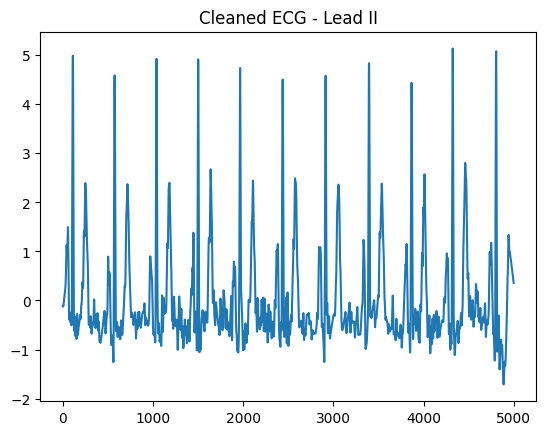

In [14]:

def bandpass_filter(sig, fs=100, low=0.5, high=40):
    nyq = 0.5 * fs
    b, a = butter(4, [low / nyq, high / nyq], btype="band")
    return filtfilt(b, a, sig)

def preprocess(sig, fs=100):
    f = bandpass_filter(sig, fs)
    f -= np.median(f)
    return (f - np.mean(f)) / np.std(f)

ecg_cleaned = preprocess(lead_sig, fs)
plt.plot(ecg_cleaned)
plt.title("Cleaned ECG - Lead II")
plt.show()


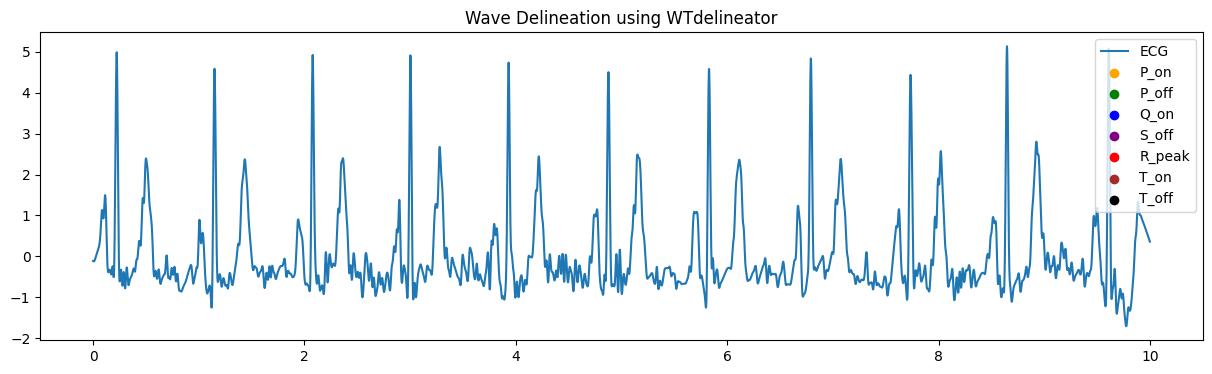

Valid P_on points: 0
Valid Q_on points: 0
Valid R_peaks: 0


In [17]:

def clean_indices(indices, length):
    """Convert to int and keep only valid indices within signal length."""
    return np.array([int(i) for i in indices if i > 0 and i < length], dtype=int)

# Clean indices
P_on_idx  = clean_indices(P_on, len(ecg_cleaned))
P_off_idx = clean_indices(P_off, len(ecg_cleaned))
Q_on_idx  = clean_indices(Q_on, len(ecg_cleaned))
S_off_idx = clean_indices(S_off, len(ecg_cleaned))
R_pk_idx  = clean_indices(R_pk, len(ecg_cleaned))
T_on_idx  = clean_indices(T_on, len(ecg_cleaned))
T_off_idx = clean_indices(T_off, len(ecg_cleaned))

# Plot
t = np.arange(len(ecg_cleaned)) / fs
plt.figure(figsize=(15, 4))
plt.plot(t, ecg_cleaned, label="ECG")
plt.scatter(t[P_on_idx], ecg_cleaned[P_on_idx], c="orange", label="P_on")
plt.scatter(t[P_off_idx], ecg_cleaned[P_off_idx], c="green", label="P_off")
plt.scatter(t[Q_on_idx], ecg_cleaned[Q_on_idx], c="blue", label="Q_on")
plt.scatter(t[S_off_idx], ecg_cleaned[S_off_idx], c="purple", label="S_off")
plt.scatter(t[R_pk_idx], ecg_cleaned[R_pk_idx], c="red", label="R_peak")
plt.scatter(t[T_on_idx], ecg_cleaned[T_on_idx], c="brown", label="T_on")
plt.scatter(t[T_off_idx], ecg_cleaned[T_off_idx], c="black", label="T_off")
plt.legend()
plt.title("Wave Delineation using WTdelineator")
plt.show()


print("Valid P_on points:", len(P_on_idx))
print("Valid Q_on points:", len(Q_on_idx))
print("Valid R_peaks:", len(R_pk_idx))


In [ ]:

# Feature Extraction
def compute_area(signal, start_idx, end_idx):
    return np.trapz(np.abs(signal[start_idx:end_idx])) if end_idx > start_idx else np.nan

def compute_slope(signal, idx1, idx2):
    return (signal[idx2] - signal[idx1]) / (idx2 - idx1) if idx2 > idx1 else np.nan

def measure_st_elevation(signal, j_point, fs=100):
    idx = int(j_point + 0.08 * fs)
    baseline = np.mean(signal[: int(0.2 * fs)])
    return signal[idx] - baseline if idx < len(signal) else np.nan

def zero_crossings(signal):
    return ((signal[:-1] * signal[1:]) < 0).sum()

features = {}
rr = np.diff(R_pk) / fs * 1000
features["RR_mean"] = np.nanmean(rr)
features["RR_std"] = np.nanstd(rr)
features["HR"] = 60000 / features["RR_mean"] if features["RR_mean"] else np.nan
features["QRS_duration"] = np.nanmean([(s - q) / fs * 1000 for q, s in zip(Q_on, S_off) if s > q])
features["PR_interval"] = np.nanmean([(q - p) / fs * 1000 for p, q in zip(P_on, Q_on) if q > p])
features["QT_interval"] = np.nanmean([(t - q) / fs * 1000 for q, t in zip(Q_on, T_off) if t > q])
features["T_duration"] = np.nanmean([(tf - to) / fs * 1000 for to, tf in zip(T_on, T_off) if tf > to])
features["R_amp"] = np.nanmax(ecg_cleaned)
features["S_amp"] = np.nanmin(ecg_cleaned)
features["R_S_ratio"] = features["R_amp"] / abs(features["S_amp"])
features["Q_amp"] = np.nanmean([ecg_cleaned[q] for q in Q_on if q < len(ecg_cleaned)])
features["QRS_area"] = np.nanmean([compute_area(ecg_cleaned, q, s) for q, s in zip(Q_on, S_off) if s > q])
features["T_amp"] = np.nanmean([ecg_cleaned[t] for t in Twav[:, 1] if t < len(ecg_cleaned)])
tasym = []
for to, tf in zip(T_on, T_off):
    if tf > to:
        mid = (to + tf) // 2
        su, sd = compute_slope(ecg_cleaned, to, mid), compute_slope(ecg_cleaned, mid, tf)
        if sd != 0:
            tasym.append(su / abs(sd))
features["T_asymmetry"] = np.nanmean(tasym) if tasym else np.nan
features["ST_elevation"] = np.nanmean([measure_st_elevation(ecg_cleaned, j) for j in S_off])
f, Pxx = welch(ecg_cleaned, fs, nperseg=1024)
bands = {"VLF": (0, 0.5), "LF": (0.5, 4), "MF": (4, 15), "HF": (15, 40)}
for b, (lo, hi) in bands.items():
    features[f"{b}_power"] = np.trapz(Pxx[(f >= lo) & (f <= hi)], f[(f >= lo) & (f <= hi)])
features["LF_HF_ratio"] = features["LF_power"] / features["HF_power"] if features["HF_power"] > 0 else np.nan
features["dominant_freq"] = f[np.argmax(Pxx)]
Pxx_norm = Pxx / np.sum(Pxx)
features["spectral_entropy"] = -np.sum(Pxx_norm * np.log2(Pxx_norm + 1e-10))
features["mean"] = np.mean(ecg_cleaned)
features["median"] = np.median(ecg_cleaned)
features["std"] = np.std(ecg_cleaned)
features["skew"] = skew(ecg_cleaned)
features["kurt"] = kurtosis(ecg_cleaned)
features["zero_crossings"] = zero_crossings(ecg_cleaned)

df = pd.DataFrame([features])
df.to_csv("ecg_features_wtdelineator.csv", index=False)
df.head()
